In [1]:
#Desenvolvido por Ronald Albert, 118021192
import pandas as pd
import numpy as np
import time
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# Pesquisa Nacional por Amostra de Domícilios - 2015
A Pesquisa Nacional por Amostra de Domicílios - PNAD investiga anualmente, de forma permanente, características gerais da população, de educação, trabalho, rendimento e habitação e outras, com periodicidade variável, de acordo com as necessidades de informação para o país, como as características sobre migração, fecundidade, nupcialidade, saúde, segurança alimentar, entre outros temas. O levantamento dessas estatísticas constitui, ao longo dos 49 anos de realização da pesquisa, um importante instrumento para formulação, validação e avaliação de políticas orientadas para o desenvolvimento socioeconômico e a melhoria das condições de vida no Brasil.

---

Para trabalhar com a Árvore de Decisão, os dados numéricos que se caracterizam como contínuos serão discretizados, e dados que já são categorizados são substituidos exatamente pela categoria que eles representam, por exemplo, no dataset original a coluna 'Sexo', pode assumir os valores 1 e 0, sendo 1 -> Masculino e 0 -> Feminino, dessa forma esses valores serão substituídos, pelas strings que, de fato, definem tal categoria.

---

Os grupos de renda serão categorizados pelos grupos de classes sociais do IBGE:<br>
E: renda menor do que 1 salario mínimo <br>
D: renda entre 1 salario mínimo e 3 salários mínimos <br>
C: renda entre 3 salários mínimos e 5 salários mínimos <br>
B: renda entre 5 salários mínimos e 15 salários mínimos <br>
A: renda maior do que 15 salários mínimos <br>

In [2]:
df = pd.read_csv('dados.csv')

def returnGender(g):
    if(g == 1):
        return "Masculino"
    else:
        return "Feminino"
    
def returnUF(u):
    return {
        11: "Rondônia",
        12: "Acre",
        13: "Amazonas",
        14: "Roraima",
        15: "Pará",
        16: "Amapá",
        17: "Tocantis",
        21: "Maranhão",
        22: "Piauí",
        23: "Ceará",
        24: "Rio Grande do Norte",
        25: "Paraíba",
        26: "Pernambuco",
        27: "Alagoas",
        28: "Sergipe",
        29: "Bahia",
        31: "Minas Gerais",
        32: "Espírito Santo",
        33: "Rio de Janeiro",
        35: "São Paulo",
        41: "Paraná",
        42: "Santa Catarina",
        43: "Rio Grande do Sul",
        50: "Mato Grosso do Sul",
        51: "Mato Grosso",
        52: "Goias",
        53: "Distrito Federal"
    }[u]

def returnEthnicGroup(e):
    return {
        0: "Indígena",
        2: "Branco",
        4: "Negro",
        6: "Asiático",
        8: "Pardo",
        9: "Sem Declaração"
    }[e]

def returnGruposDeIdade(i):
    if(i <= 18):
        return "Menor de 18 anos"
    elif(i <= 25):
        return "Entre 18 e 25 anos"
    elif(i <= 40):
        return "Entre 25 e 40 anos"
    elif (i <= 60):
        return "Entre 40 e 60 anos"
    else:
        return "Maior de 60 anos"

def returnAnosDeEstudo(e):
    if(e == 17):
        return "Não Informado"
    return e - 1

def returnClasseSocial(r):
    salario_minimo = 1100
    if(r <= salario_minimo):
        return "E"
    elif(r <= salario_minimo*3):
        return "D"
    elif(r <= salario_minimo*5):
        return "C"
    elif(r <= salario_minimo*15):
        return "B"
    else:
        return "A"


df['Sexo'] = df['Sexo'].apply(lambda x: returnGender(x))
df['UF'] = df['UF'].apply(lambda x: returnUF(x))
df['Cor'] = df['Cor'].apply(lambda x: returnEthnicGroup(x))
df['Idade'] = df['Idade'].apply(lambda x: returnGruposDeIdade(x))
df['Anos de Estudo'] = df['Anos de Estudo'].apply(lambda x: returnAnosDeEstudo(x))
df['Renda'] = df['Renda'].apply(lambda x: returnClasseSocial(x))

# Entropia e Indice de Gini

São definidos as funções para cáculo de entropia e ganho de determinada que serão usados na construção da Árvore de Decisão.

In [3]:
def calcularEntropia(df, coluna):
    values = df[coluna].unique()
    entropia = 0
    for i in values:
        pi = len(df[df[coluna].eq(i)])/len(df)
        entropia += pi*np.log2(pi)
    return -entropia
    
def calcularGanho(df, resultado, coluna):
    values = df[coluna].unique()
    ganho = 0
    for i in values:
        pi = len(df[df[coluna].eq(i)])/len(df)
        ganho += pi * calcularEntropia(df[df[coluna].eq(i)], resultado)
    ganho = calcularEntropia(df, resultado) - ganho
    return ganho

def calcularIndiceDeGiniParaValor(df, resultado, valor, coluna):
    gini = 0
    for value in df[resultado].unique():
        pi = len(df[df[coluna].eq(valor) & df[resultado].eq(value)])/len(df[df[coluna].eq(valor)])
        gini += pi * pi
    gini = 1 - gini
    return gini
    
def calcularIndiceDeGini(df, resultado, coluna):
    values = df[coluna].unique()
    gini = 0
    for i in values:
        pi = len(df[df[coluna].eq(i)])/len(df)
        gini += calcularIndiceDeGiniParaValor(df, resulado, i, coluna) * pi
    
    return gini

# A árvore de decisão

A classe nó abaixo é a definição da arvóre, sendo a variável 'atributo' o atributo do dataset que representa aquele específico Nó, no caso do dataset em questão os possíveis atributos de um Nó são: ('Anos de Estudo', 'Sexo', 'Idade', 'Cor' e 'UF'), todo o nó final de uma arvóres terá como atributo um determinado valor da coluna que se procura prever, no caso do exemplo os atributos no ultimo nó de uma árvore podem ser ('A', 'B', 'C', 'D' e 'E') e a váriavel galho assumirá a string '.'<br>

A variável galhos da classe Nó, representa os próximos níveis da árvore a partir do corrente nó, a variável é um dicionário, cuja as chaves são os possíveis valores do atributo daquele nó, e os valores de cada uma das chaves do dicionário 'galhos', são os nós do seguinte nível da árvores.
Como exemplo uma variável galhos de um Nó, cujo atributo é 'Sexo', terá como valor:<br>
`{
    "Masculino": Proximo Nó,
    "Feminino": Proximo Nó
}`

---
O algoritmo de implementação da Árvore de Decisão, usa a variável funcao (definidas anteriormente, calcularGanho() e calcularIndiceDeGini()) para decidir qual a melhor coluna para caracterizar o primeiro nó da árvore, e constroi os seguintes nós a partir desse de forma recursiva com os critérios de parada sendo, o dataset se torna vazio, o dataframe ter somente um valor da coluna de resultado (no caso do exemplo, 'Renda'), e não existirem mais colunas para serem avalidas, desse forma a árvore retornará o nó inicial que por sua vez referencia todos os outros.

In [4]:
class No:
    def __init__(self, atributo, galhos):
        self.atributo = atributo
        self.galhos = galhos
        
def construirArvoreDeDecisao(df, colunas, resultado, resultadoAnterior=0, funcao=calcularGanho, dfOriginal=df):
    if(len(df[resultado]) == 0):
        return No(resultadoAnterior, '.')
    elif(len(df[resultado].unique()) == 1):
        return No(df[resultado].iloc[0], '.')
    elif(len(colunas) == 0):
        return No(df[resultado].value_counts().index[0], '.')
    
    maiorGanhoDeColunas = -np.inf
    for i in colunas:
        atualGanho = funcao(df, resultado, i)
        if maiorGanhoDeColunas < atualGanho:
            colunaEscolhida = i
            maiorGanhoDeColunas = atualGanho
    
    galhos = {}
    for i in dfOriginal[colunaEscolhida].unique():
        galhos[i] = construirArvoreDeDecisao(df[df[colunaEscolhida].eq(i)], list(set(colunas) - set([colunaEscolhida])), resultado, df[resultado].value_counts().index[0], funcao, dfOriginal)
        
    return No(colunaEscolhida, galhos)

# Buscar na Àrvore

A função de buscar na árvore, desce pelos nó da árvore até encontrar o valor '.' na variável galhos, o que indica o final da árvore, tal busca é realizada de maneira recursiva.

---

A entrada para a função são a árvore e uma variável indivíduo, que é um dicionário cujas chaves são as colunas (com execeção da coluna resultado), e os valores são os valores que determinado indivíduo possui para aquelas colunas.

In [5]:
def buscarNaArvore(arvore, individuo):
    if(arvore.galhos == '.'):
        return arvore.atributo
    else:
        return buscarNaArvore(arvore.galhos[individuo[arvore.atributo]], individuo)

# K-Fold Validation

Na seguinte célula são realizados 10 experimentos seguindo o 5-fold validation, são 5 experimentos de k-fold validation com k igual a 5 usando como função o cálculo de ganho e outros 5 usando como função o índice de gini.

---

O resultado de cada um dos experimentos é uma tabelas com linhas ['A', 'B', 'C', 'D', 'E', 'Total'] e colunas ['A', 'B', 'C', 'D', 'E', 'Total', 'Precisão', 'Reconhecimento'].<br>
As colunas referentes as classes e a coluna 'Total' representam todos os indivíduos do dataset que foram classificados daquela maneira, enquanto as linhas referentes as classes e a linha 'Total' representam todas os indivíduos do dataset, que foram classificados daquela maneira pela Árvore de Decisão. Como exemplo, o valor na coluna 'B' e linha 'C', representam todos os indivuos que são realmente da classe social 'B', mas que foram classificados como 'C' pela Árvore de Decisão. <br>

A coluna 'Precisão' do dataframe na linha 'A', é a proporção de todos os indivíduos que o algoritmo corretamente classificou como 'A' pela quantidade de indivíduos classificados, pelo algoritmo como A.<br>
A coluna 'Reconhecimento' do dataframe na linha 'A', é a proporção de todos os indivíduos que o algoritmo corretamente classificou como 'A' pela quantidade de indivíduos que são realmente da classe social 'A'.


In [6]:
def kFoldValidation(k, df, funcao=calcularGanho):
    resto = len(df) % k
    resultadosExperimentos = []
    resultadosBusca = {}
    
    for i in range(0, k):
        df = df.sample(frac=1)
        teste = df.iloc[int((i/k)*len(df)):int(((i+1)/k)*len(df) + 1)]
        treinamento = df.iloc[:int((i/k)*len(df))].append(df.iloc[int(((i+1)/k)*len(df) + 1):])
        arvore = construirArvoreDeDecisao(treinamento, ['UF', 'Sexo', 'Idade', 'Cor', 'Anos de Estudo'], 'Renda', funcao)
        for r in df['Renda'].unique():
            resultadosBusca[r] = {}
            for f in df['Renda'].unique():
                resultadosBusca[r][f] = 0
        for e in teste.values:
            v = buscarNaArvore(arvore, {'UF': e[0], 'Sexo': e[1], 'Idade': e[2], 'Cor': e[3], 'Anos de Estudo': e[4]})
            resultadosBusca[e[5]][v] += 1
        
        dfAux = pd.DataFrame.from_dict(resultadosBusca)
        dfAux = dfAux.sort_index(ascending=True).sort_index(axis=1,ascending=True)
        dfAux['Total'] = dfAux.sum(axis=1)
        dfAux.loc['Total'] = dfAux.sum(axis=0)
        dfAux['Precisão'] = np.divide(np.diag(dfAux), dfAux['Total'])
        dfAux['Precisão']['Total'] = np.sum(np.diag(dfAux)[:-1])/dfAux['Total'].loc['Total']
        dfAux['Reconhecimento'] = np.divide(np.diag(dfAux), dfAux.loc['Total'][:-1])
        dfAux['Reconhecimento']['Total'] = np.sum(np.diag(dfAux)[:-1])/dfAux['Total'].loc['Total']
        resultadosExperimentos.append(dfAux.copy())
    
    return resultadosExperimentos

kfoldResultsEntropia = kFoldValidation(5, df)
kfoldResultsIndiceDeGini = kFoldValidation(5, df, calcularIndiceDeGini)

# Resultados Entropia

Resultados dos experimento usando a função de ganho como parâmetro para escolher as colunas

In [7]:
pd.DataFrame.from_dict(kfoldResultsEntropia[0])

,A,B,C,D,E,Total,Precisão,Reconhecimento
A,0,0,0,2,2,4,0.000000,0.000000
B,56,261,165,201,40,723,0.360996,0.343874
C,8,39,63,107,23,240,0.262500,0.056351
D,34,406,755,4177,2140,7512,0.556044,0.678746
E,5,53,135,1667,5030,6890,0.730044,0.695232
Total,103,759,1118,6154,7235,15369,0.620144,0.620144


In [8]:
pd.DataFrame.from_dict(kfoldResultsEntropia[1])

,A,B,C,D,E,Total,Precisão,Reconhecimento
A,0,2,1,3,1,7,0.000000,0.000000
B,53,271,168,182,34,708,0.382768,0.337065
C,2,38,50,64,35,189,0.264550,0.043365
D,43,452,811,4192,2141,7639,0.548763,0.685752
E,5,41,123,1672,4985,6826,0.730296,0.692746
Total,103,804,1153,6113,7196,15369,0.617997,0.617997


In [9]:
pd.DataFrame.from_dict(kfoldResultsEntropia[2])

,A,B,C,D,E,Total,Precisão,Reconhecimento
A,0,4,1,1,1,7,0.000000,0.000000
B,45,248,158,183,51,685,0.362044,0.308075
C,4,41,56,82,26,209,0.267943,0.048951
D,46,465,772,4172,2070,7525,0.554419,0.676833
E,4,47,157,1726,5009,6943,0.721446,0.699874
Total,99,805,1144,6164,7157,15369,0.617151,0.617151


In [10]:
pd.DataFrame.from_dict(kfoldResultsEntropia[3])

,A,B,C,D,E,Total,Precisão,Reconhecimento
A,0,1,1,2,1,5,0.000000,0.000000
B,59,278,171,200,31,739,0.376184,0.363399
C,5,46,52,78,23,204,0.254902,0.046470
D,49,397,762,4133,2143,7484,0.552245,0.670180
E,4,43,133,1754,5003,6937,0.721205,0.694765
Total,117,765,1119,6167,7201,15369,0.615915,0.615915


In [11]:
pd.DataFrame.from_dict(kfoldResultsEntropia[4])

,A,B,C,D,E,Total,Precisão,Reconhecimento
A,0,2,0,2,0,4,0.000000,0.000000
B,52,257,169,203,41,722,0.355956,0.325729
C,5,32,39,63,30,169,0.230769,0.034483
D,48,445,779,4211,2043,7526,0.559527,0.676575
E,2,53,144,1745,5003,6947,0.720167,0.702965
Total,107,789,1131,6224,7117,15368,0.618818,0.618818


# Resultados Indice de Gini

Resultados dos experimento usando o Indice de Gini como parâmetro para escolher as colunas

In [12]:
pd.DataFrame.from_dict(kfoldResultsIndiceDeGini[0])

,A,B,C,D,E,Total,Precisão,Reconhecimento
A,0,3,1,2,2,8,0.000000,0.000000
B,45,248,166,194,41,694,0.357349,0.319176
C,4,39,53,83,35,214,0.247664,0.047279
D,45,440,766,4231,1983,7465,0.566778,0.675016
E,3,47,135,1758,5045,6988,0.721952,0.709963
Total,97,777,1121,6268,7106,15369,0.623137,0.623137


In [13]:
pd.DataFrame.from_dict(kfoldResultsIndiceDeGini[1])

,A,B,C,D,E,Total,Precisão,Reconhecimento
A,0,0,1,4,3,8,0.000000,0.000000
B,62,231,187,195,32,707,0.326733,0.312162
C,9,36,50,90,24,209,0.239234,0.042699
D,42,421,818,4180,2067,7528,0.555260,0.673542
E,4,52,115,1737,5009,6917,0.724158,0.702032
Total,117,740,1171,6206,7135,15369,0.616175,0.616175


In [14]:
pd.DataFrame.from_dict(kfoldResultsIndiceDeGini[2])

,A,B,C,D,E,Total,Precisão,Reconhecimento
A,1,1,1,2,1,6,0.166667,0.009804
B,56,239,173,174,35,677,0.353028,0.293252
C,6,72,58,98,28,262,0.221374,0.050260
D,36,454,786,4173,2053,7502,0.556252,0.675243
E,3,49,136,1733,5001,6922,0.722479,0.702585
Total,102,815,1154,6180,7118,15369,0.616306,0.616306


In [15]:
pd.DataFrame.from_dict(kfoldResultsIndiceDeGini[3])

,A,B,C,D,E,Total,Precisão,Reconhecimento
A,0,3,1,3,1,8,0.000000,0.000000
B,60,247,187,193,38,725,0.340690,0.317889
C,6,52,50,97,35,240,0.208333,0.043328
D,56,425,778,4100,2013,7372,0.556158,0.659376
E,4,50,138,1825,5007,7024,0.712842,0.705808
Total,126,777,1154,6218,7094,15369,0.611881,0.611881


In [16]:
pd.DataFrame.from_dict(kfoldResultsIndiceDeGini[4])

,A,B,C,D,E,Total,Precisão,Reconhecimento
A,0,1,0,0,1,2,0.000000,0.000000
B,58,239,151,179,35,662,0.361027,0.295792
C,3,35,45,91,34,208,0.216346,0.040179
D,56,474,799,4161,2202,7692,0.540952,0.676585
E,1,59,125,1719,4900,6804,0.720165,0.683212
Total,118,808,1120,6150,7172,15368,0.608082,0.608082


A seguir será construido o dataframe para trabalhar com o método de Árvore de decisão da biblioteca sklearn

In [17]:
sklearnDf = pd.get_dummies(df[['Sexo','UF','Cor','Idade', 'Anos de Estudo']])
sklearnDf

,Sexo_Feminino,Sexo_Masculino,UF_Acre,UF_Alagoas,UF_Amapá,UF_Amazonas,UF_Bahia,UF_Ceará,UF_Distrito Federal,UF_Espírito Santo,...,Anos de Estudo_7,Anos de Estudo_8,Anos de Estudo_9,Anos de Estudo_10,Anos de Estudo_11,Anos de Estudo_12,Anos de Estudo_13,Anos de Estudo_14,Anos de Estudo_15,Anos de Estudo_Não Informado
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
1,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
2,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,1,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76835,0,1,0,0,0,0,0,0,1,0,...,0,0,0,1,0,0,0,0,0,0
76836,1,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
76837,1,0,0,0,0,0,0,0,1,0,...,0,0,0,0,1,0,0,0,0,0
76838,1,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [18]:
clf = DecisionTreeClassifier(criterion="entropy")

clf = clf.fit(sklearnDf[:15368*4], df.Renda[:15368*4])

# K-Fold Validation Scikit
Aqui temos a implementação do método k-fold validation, como no exemplo anterior, com a exceção de que, dessa vez usamos o método com a ávore construida pela biblioteca do scikit learn.

---

Apesar de usarmos um diferente método de construção de árvore o retorno dos experimentos é o mesma tabela.

In [19]:
def kFoldValidationScikit(k, df, criterio="entropy"):
    resto = len(df) % k
    resultadosExperimentos = []
    resultadosBusca = {}
    
    for i in range(0, k):
        df = df.sample(frac=1)
        teste = df.iloc[int((i/k)*len(df)):int(((i+1)/k)*len(df) + 1)]
        treinamento = df.iloc[:int((i/k)*len(df))].append(df.iloc[int(((i+1)/k)*len(df) + 1):])
        arvore = DecisionTreeClassifier(criterion=criterio).fit(pd.get_dummies(treinamento[['Sexo','UF','Cor','Idade', 'Anos de Estudo']]), treinamento['Renda'])
        for r in df['Renda'].unique():
            resultadosBusca[r] = {}
            for f in df['Renda'].unique():
                resultadosBusca[r][f] = 0
        prediction = clf.predict(pd.get_dummies(teste[['Sexo','UF','Cor','Idade', 'Anos de Estudo']]))       
        for e in range(len(prediction)):
            resultadosBusca[teste['Renda'].iloc[e]][prediction[e]] += 1 
        
        dfAux = pd.DataFrame.from_dict(resultadosBusca)
        dfAux = dfAux.sort_index(ascending=True).sort_index(axis=1,ascending=True)
        dfAux['Total'] = dfAux.sum(axis=1)
        dfAux.loc['Total'] = dfAux.sum(axis=0)
        dfAux['Precisão'] = np.divide(np.diag(dfAux), dfAux['Total'])
        dfAux['Precisão']['Total'] = np.sum(np.diag(dfAux)[:-1])/dfAux['Total'].loc['Total']
        dfAux['Reconhecimento'] = np.divide(np.diag(dfAux), dfAux.loc['Total'][:-1])
        dfAux['Reconhecimento']['Total'] = np.sum(np.diag(dfAux)[:-1])/dfAux['Total'].loc['Total']
        resultadosExperimentos.append(dfAux.copy())
    
    return resultadosExperimentos

kfoldResultsEntropia = kFoldValidationScikit(5, df, 'entropy')
kfoldResultsIndiceDeGini = kFoldValidationScikit(5, df, 'gini')

# Resultados Entropia

Resultados dos experimento usando a função de ganho como parâmetro para escolher as colunas

In [20]:
pd.DataFrame.from_dict(kfoldResultsEntropia[0])

,A,B,C,D,E,Total,Precisão,Reconhecimento
A,4,4,2,6,0,16,0.250000,0.036036
B,53,246,141,140,42,622,0.395498,0.309824
C,6,29,118,63,22,238,0.495798,0.105076
D,42,439,686,3737,1431,6335,0.589897,0.609525
E,6,76,176,2185,5715,8158,0.700539,0.792649
Total,111,794,1123,6131,7210,15369,0.638949,0.638949


In [21]:
pd.DataFrame.from_dict(kfoldResultsEntropia[1])

,A,B,C,D,E,Total,Precisão,Reconhecimento
A,0,2,0,2,1,5,0.000000,0.000000
B,48,255,156,141,41,641,0.397816,0.319950
C,5,36,115,77,21,254,0.452756,0.101054
D,47,448,702,3765,1474,6436,0.584991,0.613092
E,9,56,165,2156,5647,8033,0.702975,0.786052
Total,109,797,1138,6141,7184,15369,0.636476,0.636476


In [22]:
pd.DataFrame.from_dict(kfoldResultsEntropia[2])

,A,B,C,D,E,Total,Precisão,Reconhecimento
A,0,2,1,1,0,4,0.000000,0.000000
B,44,219,159,162,42,626,0.349840,0.279337
C,4,40,113,75,23,255,0.443137,0.099297
D,44,467,686,3761,1443,6401,0.587564,0.602435
E,5,56,179,2244,5599,8083,0.692688,0.787815
Total,97,784,1138,6243,7107,15369,0.630620,0.630620


In [23]:
pd.DataFrame.from_dict(kfoldResultsEntropia[3])

,A,B,C,D,E,Total,Precisão,Reconhecimento
A,3,2,1,3,0,9,0.333333,0.028846
B,44,249,147,136,39,615,0.404878,0.308168
C,5,34,103,79,29,250,0.412000,0.093044
D,49,461,682,3768,1432,6392,0.589487,0.602302
E,3,62,174,2270,5594,8103,0.690362,0.788554
Total,104,808,1107,6256,7094,15369,0.632247,0.632247


In [24]:
pd.DataFrame.from_dict(kfoldResultsEntropia[4])

,A,B,C,D,E,Total,Precisão,Reconhecimento
A,4,4,1,0,1,10,0.400000,0.037037
B,42,236,151,163,34,626,0.376997,0.306494
C,5,33,114,67,21,240,0.475000,0.098022
D,54,436,705,3818,1384,6397,0.596842,0.616303
E,3,61,192,2147,5692,8095,0.703150,0.798093
Total,108,770,1163,6195,7132,15368,0.641853,0.641853


# Resultados Indice de Gini

Resultados dos experimento usando o Indice de Gini como parâmetro para escolher as colunas

In [25]:
pd.DataFrame.from_dict(kfoldResultsIndiceDeGini[0])

,A,B,C,D,E,Total,Precisão,Reconhecimento
A,5,1,1,1,1,9,0.555556,0.047619
B,50,246,161,157,41,655,0.375573,0.316602
C,5,31,113,77,29,255,0.443137,0.099472
D,36,431,680,3755,1427,6329,0.593301,0.610768
E,9,68,181,2158,5705,8121,0.702500,0.792031
Total,105,777,1136,6148,7203,15369,0.639209,0.639209


In [26]:
pd.DataFrame.from_dict(kfoldResultsIndiceDeGini[1])

,A,B,C,D,E,Total,Precisão,Reconhecimento
A,1,2,1,1,1,6,0.166667,0.010989
B,41,260,152,160,29,642,0.404984,0.311005
C,6,42,121,77,36,282,0.429078,0.105585
D,39,467,688,3755,1430,6379,0.588650,0.614566
E,4,65,184,2117,5690,8060,0.705955,0.791817
Total,91,836,1146,6110,7186,15369,0.639404,0.639404


In [27]:
pd.DataFrame.from_dict(kfoldResultsIndiceDeGini[2])

,A,B,C,D,E,Total,Precisão,Reconhecimento
A,3,4,2,3,1,13,0.230769,0.030928
B,41,239,149,156,40,625,0.382400,0.306018
C,4,33,108,76,29,250,0.432000,0.092545
D,45,432,722,3766,1427,6392,0.589174,0.601790
E,4,73,186,2257,5569,8089,0.688466,0.788140
Total,97,781,1167,6258,7066,15369,0.630165,0.630165


In [28]:
pd.DataFrame.from_dict(kfoldResultsIndiceDeGini[3])

,A,B,C,D,E,Total,Precisão,Reconhecimento
A,4,0,3,0,0,7,0.571429,0.032787
B,58,234,140,164,44,640,0.365625,0.307087
C,9,30,117,74,34,264,0.443182,0.103084
D,45,431,692,3750,1465,6383,0.587498,0.610153
E,6,67,183,2158,5661,8075,0.701053,0.785813
Total,122,762,1135,6146,7204,15369,0.635435,0.635435


In [29]:
pd.DataFrame.from_dict(kfoldResultsIndiceDeGini[4])

,A,B,C,D,E,Total,Precisão,Reconhecimento
A,2,2,1,1,0,6,0.333333,0.019048
B,49,236,158,157,34,634,0.372240,0.316779
C,4,44,110,77,26,261,0.421456,0.104662
D,46,410,614,3758,1436,6264,0.599936,0.602920
E,4,53,168,2240,5738,8203,0.699500,0.793199
Total,105,745,1051,6233,7234,15368,0.640552,0.640552


# Aplicando o post-prunning 

As seguinte células, aplicam o método da biblioteca sklearn na árvore construida de cost_complexity_prunning_path, que nos retorna uma lista de valores de 0 a 1, tais valores que representam o quanto da árvore deve ser cortado para um melhor desempenho

In [30]:
path = clf.cost_complexity_pruning_path(pd.get_dummies(df[['Sexo','UF','Cor','Idade', 'Anos de Estudo']]), df['Renda']) 
alphas = path['ccp_alphas']

Depois de construida a lista de alphas realizamos o teste para cada um deles com as árvores diferentes árvores para cada, na célula seguinte

In [31]:
accuracy_train, accuracy_test = [], []
for i in alphas[alphas>0]:
    i = i if i >= 0 else i*-1
    
    tree = DecisionTreeClassifier(ccp_alpha=i)
    
    tree.fit(sklearnDf[:15368*4], df.Renda[:15368*4])
    y_train_pred = tree.predict(sklearnDf[:15368*4])
    y_test_pred = tree.predict(sklearnDf[15368:])
    
    accuracy_train.append(metrics.accuracy_score(df.Renda[:15368*4], y_train_pred))
    accuracy_test.append(metrics.accuracy_score(df.Renda[15368:], y_test_pred))

# Desempenho do Post-Pruning
O seguinte gráfico nos mostra o desempenho do post-pruning para os exemplos de treino e de teste, o gráfico é um plot da AcuráciaXalpha de corte da Árvore.<br>
Pelo gráfico podemos perceber que o melhor desempenho do algoritmo aconteceu, quando o nosso valor para o alpha da árvore era igual a 0, ou seja, uma possível poda na Árvore pioraria o desempenho das suas previsões

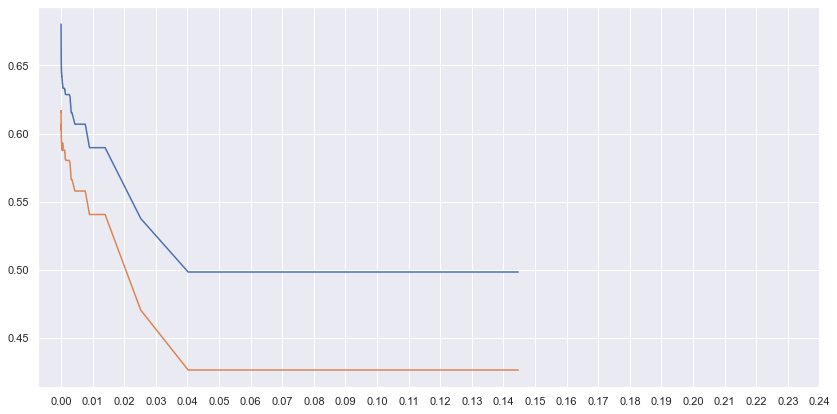

In [32]:
sns.set()
plt.figure(figsize=(14,7))
sns.lineplot(y=accuracy_train, x=alphas[alphas>0])
sns.lineplot(y=accuracy_test, x=alphas[alphas>0])
plt.xticks(ticks=np.arange(0.00, 0.25, 0.01))
plt.show()